In [86]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")


======================================== Memory Information ========================================
Total: 12.72GB
Available: 9.21GB
Used: 4.17GB
Percentage: 27.6%


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
!pip install torchtext==0.6.0
from torchtext.data.metrics import bleu_score
import matplotlib.ticker as ticker

#from torchtext.datasets import Multi30k
from torchtext.datasets import WMT14,Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

import matplotlib.pyplot as plt

In [88]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

!python -m spacy download en
!python -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [89]:
def tokenize_de(text): #tokenize german text into list of strings

    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text): #tokenize english text into list of strings

    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [90]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

#implemented partial shuffle of embeddings to keep model generalized
def partial_shuffle(data):
    M = data.shape[1]
    data = data.t()
    N = data.shape[0] # batch size
    splits = torch.from_numpy(np.random.randint(M, size=N))
    shifted = []
    for i, row in enumerate(data):
        shifted.append(torch.cat((row[splits[i]:], row[:splits[i]])))
    return torch.stack(shifted).t()

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [91]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

class Encoder(nn.Module):
    def __init__(self, in_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()        

        self.embedding = nn.Embedding(in_dim, emb_dim)        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):      

        emb = self.dropout(self.embedding(src))
        p_emb = nn.utils.rnn.pack_padded_sequence(emb, src_len.cpu())      #packed embedding          
        p_out, hid = self.rnn(p_emb)                                       #packed output is packed seq of all hidden states           
        out, _ = nn.utils.rnn.pad_packed_sequence(p_out) 
        hid = torch.tanh(self.fc(torch.cat((hid[-2,:,:], hid[-1,:,:]), dim = 1)))
        epsilon = 0.005 
        hid = hid + epsilon*torch.rand(hid.shape[0],hid.shape[1]).to(device)
        return out, hid

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hid, enc_out, mask):

        batch_size = enc_out.shape[1]
        src_len = enc_out.shape[0]
        hid = hid.unsqueeze(1).repeat(1, src_len, 1) 
        enc_out = enc_out.permute(1, 0, 2)       
        activation = torch.tanh(self.attn(torch.cat((hid, enc_out), dim = 2))) 

        att = self.v(activation).squeeze(2)
        att = att.masked_fill(mask == 0, -1e10)
        temp = 1
        return F.softmax(att/temp, dim = 1)

class Decoder(nn.Module):
    def __init__(self, out_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, att):
        super().__init__()

        self.output_dim = out_dim
        self.attention = att
        self.fc_noise=nn.Linear(2*enc_hid_dim,dec_hid_dim)
        if self.attention is not None:
            self.embedding = nn.Embedding(out_dim, emb_dim)
            
            self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
            
            self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, out_dim)
            
            self.dropout = nn.Dropout(dropout)
        else:
            self.embedding = nn.Embedding(out_dim, emb_dim)
            self.rnn = nn.GRU(emb_dim, dec_hid_dim)
            self.fc_out = nn.Linear(dec_hid_dim + emb_dim, out_dim)
            self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hid, enc_out, mask):

        input = input.unsqueeze(0)
        emb = self.dropout(self.embedding(input))

        if self.attention == None:
            rnn_input = emb
            out, hid = self.rnn(rnn_input, hid.unsqueeze(0))
            assert (out == hid).all()
            
            emb = emb.squeeze(0)
            out = out.squeeze(0)
            latent=torch.cat((out, emb), dim = 1)
            pred = self.fc_out(torch.cat((out,emb), dim = 1))
            return pred, hid.squeeze(0), hid.squeeze(0)
        else:
            a = self.attention(hid, enc_out, mask)
            a = a.unsqueeze(1)        
            enc_out = enc_out.permute(1, 0, 2)         
            weighted = torch.bmm(a, enc_out)            
            weighted = weighted.permute(1, 0, 2)            
            rnn_input = torch.cat((emb, weighted), dim = 2)        
            out, hid = self.rnn(rnn_input, hid.unsqueeze(0))
            
            assert (out == hid).all()
            
            emb = emb.squeeze(0)
            out = out.squeeze(0)
            weighted = weighted.squeeze(0)
            epsilon = 0.005
            noise = epsilon*self.fc_noise(weighted)
            out = out + noise

            latent=torch.cat((out, weighted, emb), dim = 1)            
            pred = self.fc_out(torch.cat((out, weighted, emb), dim = 1))

            return pred, hid.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src, src_len)
        input = trg[0,:]
        
        mask = self.create_mask(src)
                
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            outputs[t] = output            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
            
        return outputs

In [92]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
# dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, None)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


The model has 8,788,101 trainable parameters


In [93]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [94]:
#Training and Evaluating functions
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    example_idx = 12
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            if i==example_idx:
                src, src_len = batch.src
                trg = batch.trg
                print(f'src = {src}')
                print(f'trg = {trg}')
                translation, attention = translate_sentence(src, SRC, TRG, model, device)
                print(f'predicted trg = {translation}')
            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [95]:
N_EPOCHS = 20
CLIP = 1
import time
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')



Epoch: 01 | Time: 0m 29s
	Train Loss: 5.220 | Train PPL: 184.890
	 Val. Loss: 4.853 |  Val. PPL: 128.090
Epoch: 02 | Time: 0m 29s
	Train Loss: 4.419 | Train PPL:  82.972
	 Val. Loss: 4.627 |  Val. PPL: 102.242
Epoch: 03 | Time: 0m 29s
	Train Loss: 4.039 | Train PPL:  56.758
	 Val. Loss: 4.334 |  Val. PPL:  76.262
Epoch: 04 | Time: 0m 29s
	Train Loss: 3.664 | Train PPL:  39.007
	 Val. Loss: 3.943 |  Val. PPL:  51.565
Epoch: 05 | Time: 0m 28s
	Train Loss: 3.252 | Train PPL:  25.842
	 Val. Loss: 3.666 |  Val. PPL:  39.086
Epoch: 06 | Time: 0m 29s
	Train Loss: 2.947 | Train PPL:  19.052
	 Val. Loss: 3.514 |  Val. PPL:  33.566
Epoch: 07 | Time: 0m 28s
	Train Loss: 2.701 | Train PPL:  14.889
	 Val. Loss: 3.435 |  Val. PPL:  31.024
Epoch: 08 | Time: 0m 29s
	Train Loss: 2.488 | Train PPL:  12.035
	 Val. Loss: 3.301 |  Val. PPL:  27.128
Epoch: 09 | Time: 0m 29s
	Train Loss: 2.321 | Train PPL:  10.191
	 Val. Loss: 3.291 |  Val. PPL:  26.863
Epoch: 10 | Time: 0m 29s
	Train Loss: 2.194 | Train PPL

In [96]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

#Calculates Bleu score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score2 = calculate_bleu(test_data, SRC, TRG, model, device)



src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']
predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', 'fighting', '.', '<eos>']


In [97]:
#Function for visualing the attention from network
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
        
    ax = fig.add_subplot(n_rows, n_cols,1)

    _attention = attention[:,:,1:].squeeze().cpu().detach().numpy() 
    cax = ax.matshow(_attention, cmap='bone')
    
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=90)
    ax.set_yticklabels(['']+translation)
      
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = drei personen , die auf einem pfad in einer wiese gehen .
trg = three people walking on a path in a meadow .
predicted trg = three people walking on a path in a meadow . <eos>


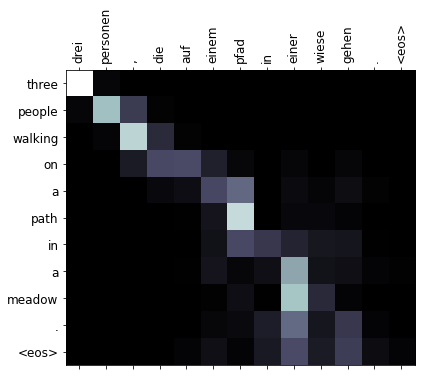

In [98]:
#Generate Attention maps
example_idx = 82

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')


translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {" ".join(translation)}')
display_attention(src, translation, attention)


In [99]:
print(f'BLEU score = {bleu_score2*100:.2f}')

BLEU score = 31.54
